# Transfer Learning with EfficientNetB0

## 1. Imports and paths

In [ ]:
import os
import sys
import time
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure NVIDIA pip libs are visible to the dynamic loader inside WSL/Linux
if sys.platform.startswith("linux") and "VIRTUAL_ENV" in os.environ:
    py_ver = f"python{sys.version_info.major}.{sys.version_info.minor}"
    site_packages = Path(os.environ["VIRTUAL_ENV"]) / "lib" / py_ver / "site-packages"
    nvidia_lib_dirs = [str(path) for path in (site_packages / "nvidia").glob("*/lib") if path.is_dir()]
    if nvidia_lib_dirs:
        previous = os.environ.get("LD_LIBRARY_PATH", "")
        os.environ["LD_LIBRARY_PATH"] = ":".join(nvidia_lib_dirs + ([previous] if previous else []))

import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.applications import EfficientNetV2B1


cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from utils.ml_utils import (
    build_tf_dataset,
    evaluate_and_log_model,
    format_duration,
    predict_and_resolve_labels,
    compute_confusion_matrix,
    build_classification_report,
    plot_confusion_matrix_notebook01,
    plot_training_curves_notebook01,
)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) detected: {len(gpus)}")
else:
    print("No GPU detected. Running on CPU.")

print("TF version:", tf.__version__)

2026-02-19 08:56:30.631192: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-19 08:56:30.666048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-19 08:56:31.200567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU(s) detectada(s): 1
TF version: 2.16.1


2026-02-19 08:56:31.943325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 08:56:31.982957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 08:56:31.983001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
PROJECT_ROOT = os.getcwd()
if os.path.basename(PROJECT_ROOT).lower() == 'notebooks':
    PROJECT_ROOT = os.path.dirname(PROJECT_ROOT)
elif os.path.basename(PROJECT_ROOT).lower() != 'cifar10_project':
    candidate = os.path.join(PROJECT_ROOT, 'cifar10_project')
    if os.path.isdir(candidate):
        PROJECT_ROOT = candidate

DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
REPORTS_DIR = os.path.join(PROJECT_ROOT, 'reports')

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

data_path = os.path.join(PROCESSED_DIR, 'cifar10_processed.npz')
performance_report_path = os.path.join(DATA_DIR, 'model_performance_report.csv')
print("Data path:", data_path)
print("Performance report path:", performance_report_path)


Data path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/processed/cifar10_processed.npz
Performance report path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/model_performance_report.csv


## 2. Load processed data

In [3]:
data = np.load(data_path)

x_train = data["x_train"]
y_train = data["y_train"]
x_val   = data["x_val"]
y_val   = data["y_val"]
x_test  = data["x_test"]
y_test  = data["y_test"]

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape,   y_val.shape)
print("Test: ", x_test.shape,  y_test.shape)

num_classes = 10

# One-hot labels for transfer learning
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val,   num_classes)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)


Train: (40000, 32, 32, 3) (40000, 1)
Val:   (10000, 32, 32, 3) (10000, 1)
Test:  (10000, 32, 32, 3) (10000, 1)


## 3. Data pipeline with resizing to EfficientNetB0 input

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def augment(image, label):
    image = tf.image.random_flip_left_right(image)

    img_shape = tf.shape(image)
    scale = tf.random.uniform([], 0.85, 1.0)
    new_size = tf.cast(tf.cast(img_shape[:2], tf.float32) * scale, tf.int32)
    image = tf.image.random_crop(image, size=[new_size[0], new_size[1], 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.02)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0, 1.0)

    return image, label

train_ds = build_tf_dataset(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    shuffle_buffer=10000,
    augment_fn=augment,
    autotune=AUTOTUNE,
)

val_ds = build_tf_dataset(
    x=x_val,
    y=y_val,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    autotune=AUTOTUNE,
)

test_ds = build_tf_dataset(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    autotune=AUTOTUNE,
)


2026-02-19 08:56:33.276522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 08:56:33.276590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 08:56:33.276606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 08:56:33.393461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 08:56:33.393510: I external/local_xla/xla/stream_executor

## 4. Build EfficientNetV2B1 transfer learning model

In [5]:
def build_efficientnet_cifar10(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Undo the [0,1] normalization to [0,255]
    # EfficientNetB0 expects pixels in the range [0, 255]
    x = layers.Lambda(lambda val: val * 255.0)(inputs)

    # Define the base model
    base_model = EfficientNetV2B1(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg"
    )

    base_model.trainable = False

    # Connect scaled inputs to the base_model
    # training=False ensures BatchNormalization stays in inference mode
    x = base_model(x, training=False)

    # Classification head
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model, base_model

model, base_model = build_efficientnet_cifar10()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b1 (Functional)  │ (None, 1280)           │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,943,934 (26.49 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 6,931,124 (26.44 MB)

## 5. Compile and train (feature extraction stage)

In [6]:
epochs_stage1 = 50
initial_lr = 1e-3

_time = __import__("time")
train_start_time = _time.time()

stage1_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    ),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_stage1,
    callbacks=stage1_callbacks,
    verbose=1,
    validation_freq=1,
)


Epoch 1/50


I0000 00:00:1771491402.480829   14063 service.cc:145] XLA service 0x748f34014c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771491402.480882   14063 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2026-02-19 08:56:42.750406: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-19 08:56:43.728288: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.1250 - loss: 2.4859   

I0000 00:00:1771491425.043509   14063 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6921 - loss: 1.2555

I0000 00:00:1771491435.268741   14411 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2843', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1771491435.327074   14401 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2843', 228 bytes spill stores, 228 bytes spill loads

I0000 00:00:1771491438.881317   14478 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2843', 20 bytes spill stores, 20 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - accuracy: 0.7814 - loss: 1.0548 - val_accuracy: 0.8712 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8339 - loss: 0.9353 - val_accuracy: 0.8763 - val_loss: 0.8221 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8373 - loss: 0.9223 - val_accuracy: 0.8794 - val_loss: 0.8177 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8407 - loss: 0.9160 - val_accuracy: 0.8796 - val_loss: 0.8143 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8394 - loss: 0.9164 - val_accuracy: 0.8822 - val_loss: 0.8091 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8402 - loss: 0.9143 - val_accuracy: 0.8809 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8423 - loss: 0.9164 - val

## 6. Fine‑tuning: unfreeze top layers

In [7]:
# Unfreeze some top layers for fine-tuning
base_model.trainable = True

# Optionally, freeze lower layers to avoid overfitting
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_lr = 1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"],
)

epochs_stage2 = 190

stage2_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=8,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.2,
        patience=8,
        min_lr=1e-9,
        verbose=1,
    ),
]

history_stage2 = model.fit(
    train_ds,
    epochs=epochs_stage1 + epochs_stage2,
    initial_epoch=history_stage1.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=stage2_callbacks,
    verbose=1,
    validation_freq=1,
)

_time = __import__("time")
if "train_start_time" in globals():
    train_duration_sec = _time.time() - train_start_time
    print(f"Training time: {format_duration(train_duration_sec)} ({train_duration_sec:.2f} sec)")
else:
    train_duration_sec = None
    print("Training finished, but `train_start_time` was not found. Re-run cell 12 before this one to log full duration.")


Epoch 13/240
  1/625 ━━━━━━━━━━━━━━━━━━━━ 7:10:26 41s/step - accuracy: 0.5625 - loss: 1.4578

I0000 00:00:1771491578.512039   14065 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 36 bytes spill stores, 36 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - accuracy: 0.8257 - loss: 0.7774 - val_accuracy: 0.9107 - val_loss: 0.5332 - learning_rate: 1.0000e-04
Epoch 14/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8924 - loss: 0.5952 - val_accuracy: 0.9286 - val_loss: 0.4875 - learning_rate: 1.0000e-04
Epoch 15/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9128 - loss: 0.5347 - val_accuracy: 0.9328 - val_loss: 0.4638 - learning_rate: 1.0000e-04
Epoch 16/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9291 - loss: 0.4927 - val_accuracy: 0.9385 - val_loss: 0.4473 - learning_rate: 1.0000e-04
Epoch 17/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9377 - loss: 0.4658 - val_accuracy: 0.9408 - val_loss: 0.4445 - learning_rate: 1.0000e-04
Epoch 18/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9463 - loss: 0.4449 - val_accuracy: 0.9432 - val_loss: 0.4397 - learning_rate: 1.0000e-04
Epoch 19/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/st

## 7. Test evaluation and save model

In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Transfer learning test accuracy: {test_acc:.4f}")

history_for_log = history_stage2 if "history_stage2" in globals() else history_stage1
epochs_done = len(history_for_log.history.get("accuracy", []))
train_time_value = train_duration_sec if "train_duration_sec" in globals() else None

print(f"Using history with {epochs_done} epoch(s) for CSV logging.")
if train_time_value is not None:
    print(f"Training time used for logging: {format_duration(train_time_value)} ({train_time_value:.2f} sec)")

row = evaluate_and_log_model(
    model=model,
    model_name="EfficientNetV2B1 Transfer Learning",
    data=test_ds,
    labels=y_test,
    csv_path=performance_report_path,
    history=history_for_log,
    train_time_sec=train_time_value,
    average="macro",
    verbose=0,
    extra_fields={"test_loss": float(test_loss)},
)
print("Logged metrics:", row)

tl_model_path = os.path.join(MODELS_DIR, "EfficientNetV2B1_cifar10_tuned.keras")
model.save(tl_model_path)
print("Saved TL model to:", tl_model_path)

Transfer learning test accuracy: 0.9513
Using history with 47 epoch(s) for CSV logging.
Training time used for logging: 14 min 55 sec (895.11 sec)
Logged metrics: {'model_name': 'EfficientNetV2B1 Transfer Learning', 'num_params': 6943934, 'train_time_sec': 895.11, 'train_time': '14 min 55 sec', 'timestamp': '2026-02-19 09:11', 'accuracy': 0.9513, 'precision': 0.9511766566935836, 'recall': 0.9513, 'f1': 0.9510426516572906, 'support': 10000, 'final_accuracy': 0.9933249950408936, 'final_loss': 0.30833297967910767, 'final_val_accuracy': 0.951200008392334, 'final_val_loss': 0.428043931722641, 'final_learning_rate': 9.999999747378752e-05, 'epochs_trained': 47, 'test_loss': 0.42817753553390503}
Saved TL model to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/EfficientNetV2B1_cifar10_tuned.keras


In [9]:
tl_model_path = os.path.join(MODELS_DIR, "EfficientNetV2B1_cifar10_tuned.keras")

model = tf.keras.models.load_model(tl_model_path, safe_mode=False)
print("Loaded model:", tl_model_path)

model.summary()

Loaded model: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/EfficientNetV2B1_cifar10_tuned.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b1 (Functional)  │ (None, 1280)           │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,873,276 (68.18 MB)

 Trainable params: 5,464,670 (20.85 MB)

 Non-trainable params: 1,479,264 (5.64 MB)

 Optimizer params: 10,929,342 (41.69 MB)

Classification Report (Transfer Learning):
              precision    recall  f1-score   support

    airplane     0.9697    0.9590    0.9643      1000
  automobile     0.9721    0.9750    0.9735      1000
        bird     0.9333    0.9650    0.9489      1000
         cat     0.9241    0.8520    0.8866      1000
        deer     0.9530    0.9530    0.9530      1000
         dog     0.8981    0.9080    0.9030      1000
        frog     0.9594    0.9700    0.9647      1000
       horse     0.9683    0.9760    0.9721      1000
        ship     0.9619    0.9840    0.9728      1000
       truck     0.9720    0.9710    0.9715      1000

    accuracy                         0.9513     10000
   macro avg     0.9512    0.9513    0.9510     10000
weighted avg     0.9512    0.9513    0.9510     10000



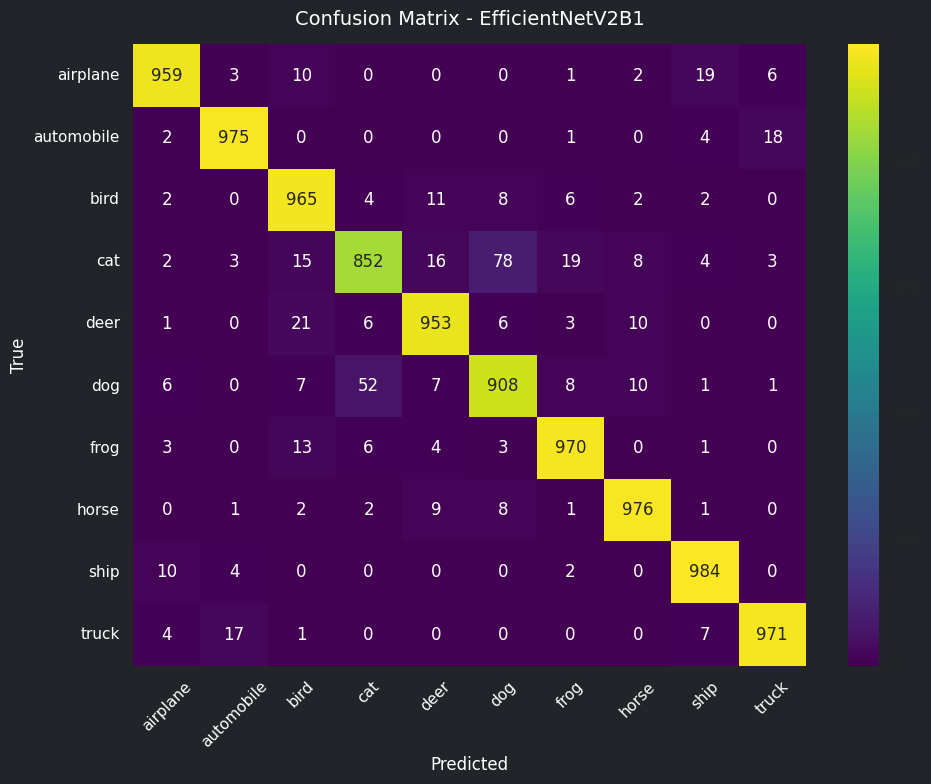

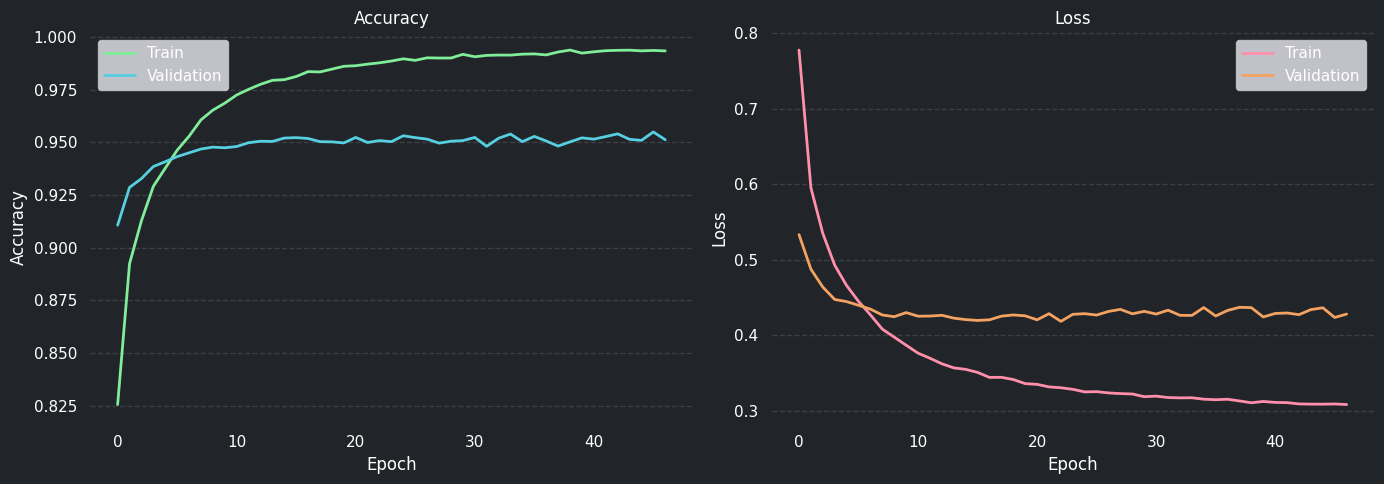

Saved curves to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/EfficientNetV2B1_curves.png


In [10]:
# Detailed metrics, confusion matrix and learning curves via utils
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_true, y_pred = predict_and_resolve_labels(model=model, data=test_ds, labels=y_test, verbose=0)

print("Classification Report (Transfer Learning):")
print(build_classification_report(y_true, y_pred, target_names=class_names))

cm = compute_confusion_matrix(y_true, y_pred)
plot_confusion_matrix_notebook01(
    confusion=cm,
    class_names=class_names,
    title='Confusion Matrix - EfficientNetV2B1',
    save_path=os.path.join(REPORTS_DIR, 'efficientnet_confusion.png'),
)

history_for_plot = history_stage2 if 'history_stage2' in globals() else history_stage1
plot_training_curves_notebook01(
    history=history_for_plot,
    save_path=os.path.join(REPORTS_DIR, 'EfficientNetV2B1_curves.png'),
)
print("Saved curves to:", os.path.join(REPORTS_DIR, 'EfficientNetV2B1_curves.png'))